         Date     Item Name  Low Price  Average Price  High Price
0  05-12-2024  કપાસ બી. ટી.       1241           1441        1491
1  05-12-2024     ઘઉં લોકવન        556            580         626
2  05-12-2024     ઘઉં ટુકડા        560            681         746
3  05-12-2024    મગફળી જીણી        721           1081        1141
4  05-12-2024   સિંગ ફાડીયા        811           1131        1261
['કપાસ બી. ટી.' 'ઘઉં લોકવન' 'ઘઉં ટુકડા' 'મગફળી જીણી' 'સિંગ ફાડીયા'
 'એરંડા / એરંડી' 'જીરૂ' 'ક્લંજી' 'વરીયાળી' 'ધાણા' 'લસણ સુકું' 'ડુંગળી લાલ'
 'અડદ' 'મઠ' 'તુવેર' 'રાય' 'મેથી' 'કાંગ' 'મરચા' 'મગફળી જાડી' 'સફેદ ચણા'
 'તલ - તલી' 'ઇસબગુલ' 'ધાણી' 'બાજરો' 'જુવાર' 'મકાઇ' 'મગ' 'ચણા' 'વાલ'
 'ચોળા / ચોળી' 'સોયાબીન' 'ગોગળી' 'વટાણા' 'રાયડો' 'તલ કાળા' 'ડુંગળી સફેદ'
 'રાજગરો' 'ગુવાર બી' 'સુવાદાણા' 'સુરજમુખી' 'અજમાં' 'કળથી'
 'મરચા સૂકા પટ્ટો' 'અરીઠા' 'સિંગદાણા જાડા' 'તલ લાલ' 'નવા ધાણા'
 'રજકાનું બી' 'નવી ધાણી' 'નવું લસણ' 'નવું જીરૂ' 'વાલ પાપડી' 'કારીજીરી'
 'નવા ચણા' 'ઘઉં નવા' 'મરચા સૂકા ઘોલર']
Data older than 06-

<Figure size 1200x600 with 0 Axes>

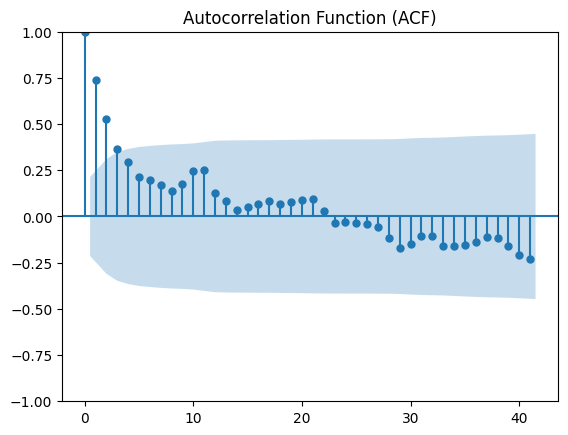

<Figure size 1200x600 with 0 Axes>

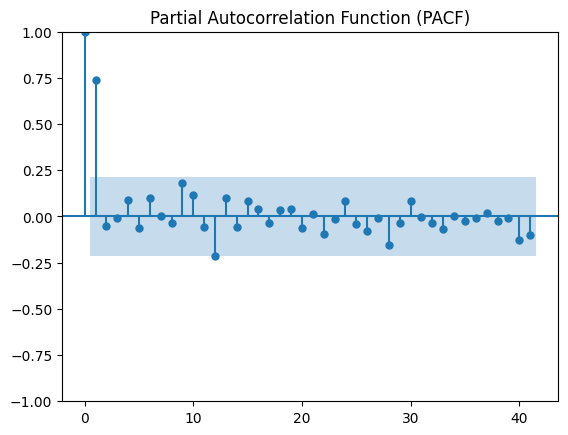


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -359.661
Date:                Sat, 05 Apr 2025   AIC                            725.322
Time:                        14:37:59   BIC                            732.615
Sample:                             0   HQIC                           728.254
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1427.9101      9.916    144.003      0.000    1408.475    1447.345
ar.L1          0.7461      0.06

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

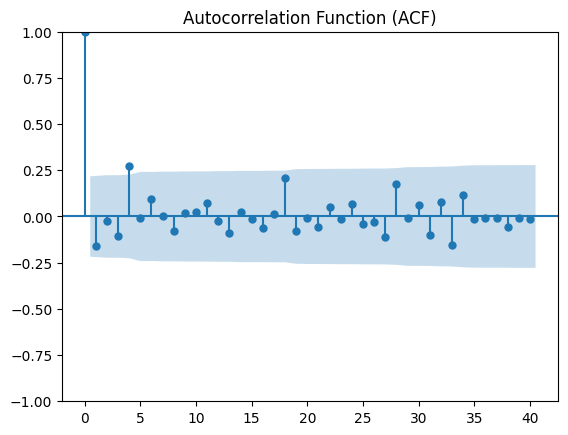

<Figure size 1200x600 with 0 Axes>

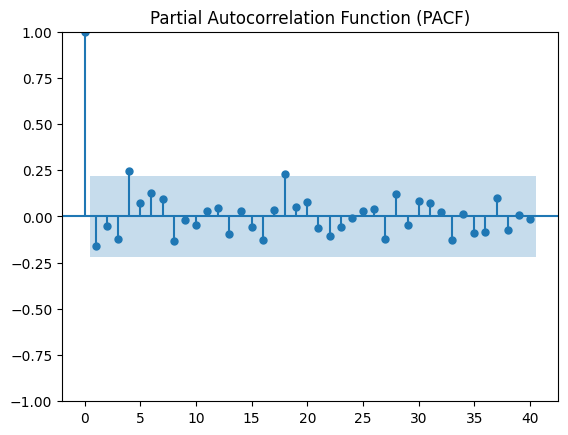


Fitting ARIMA model with order (5, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -300.435
Date:                Sat, 05 Apr 2025   AIC                            614.870
Time:                        14:38:04   BIC                            631.631
Sample:                             0   HQIC                           621.595
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3253      0.873      0.373      0.710      -1.386       2.037
ar.L2          0.0192      0.158      0.122      0.903      -0.290       0.3

<Figure size 1200x600 with 0 Axes>

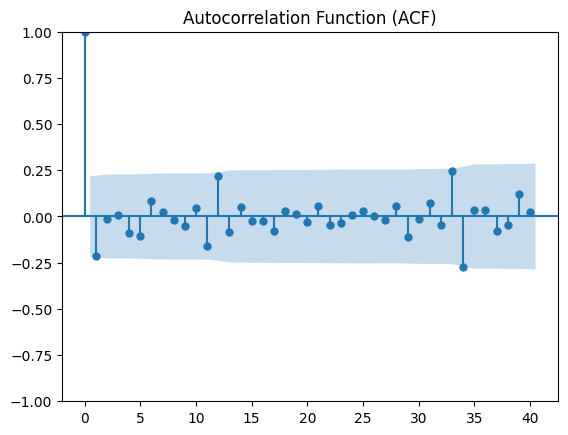

<Figure size 1200x600 with 0 Axes>

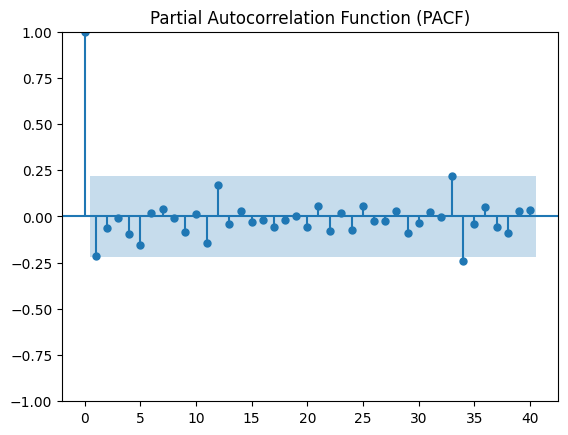


Fitting ARIMA model with order (3, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -350.966
Date:                Sat, 05 Apr 2025   AIC                            713.933
Time:                        14:38:07   BIC                            728.299
Sample:                             0   HQIC                           719.697
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4033      0.558     -0.723      0.469      -1.496       0.690
ar.L2          0.5503      0.666      0.826      0.409      -0.756       1.8

<Figure size 1200x600 with 0 Axes>

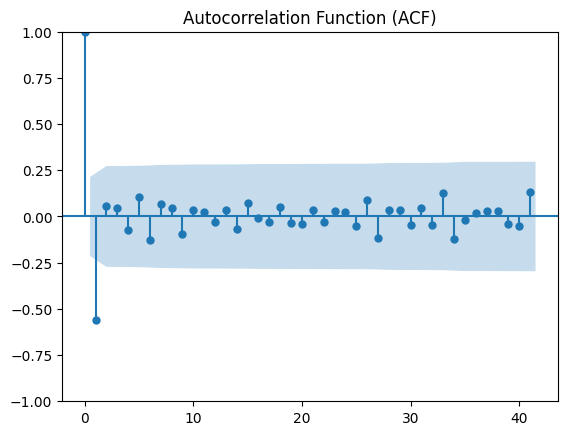

<Figure size 1200x600 with 0 Axes>

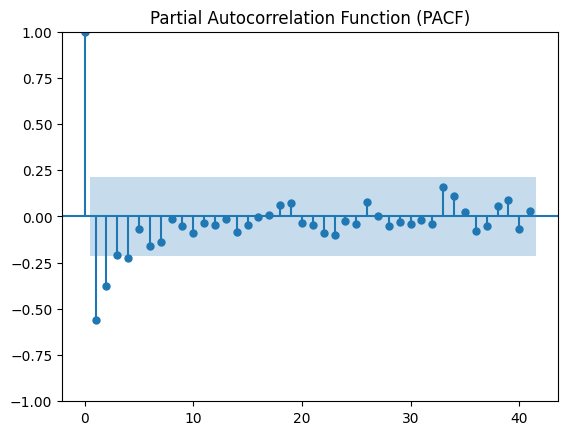


Fitting ARIMA model with order (1, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -348.038
Date:                Sat, 05 Apr 2025   AIC                            702.075
Time:                        14:38:08   BIC                            709.368
Sample:                             0   HQIC                           705.007
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1571      0.187     -0.841      0.400      -0.523       0.209
ma.L1         -0.7895      0.135     -5.861      0.000      -1.054      -0.5

<Figure size 1200x600 with 0 Axes>

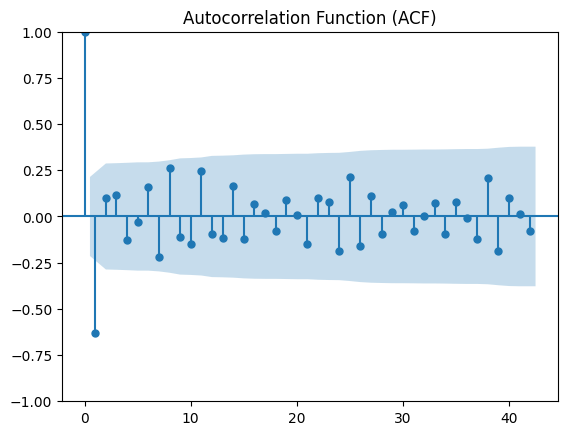

<Figure size 1200x600 with 0 Axes>

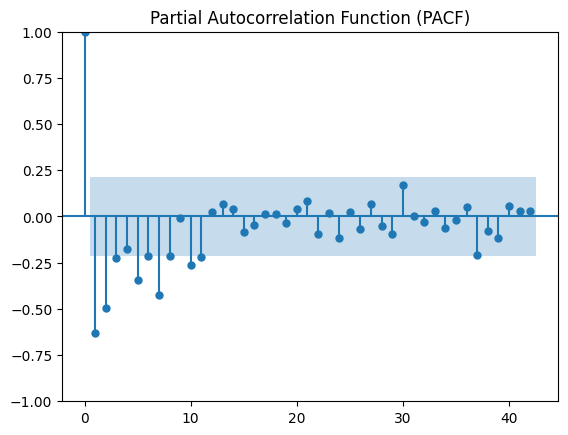


Fitting ARIMA model with order (2, 2, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -425.375
Date:                Sat, 05 Apr 2025   AIC                            860.749
Time:                        14:38:09   BIC                            872.903
Sample:                             0   HQIC                           865.635
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1766      0.172      1.028      0.304      -0.160       0.513
ar.L2         -0.0018      0.134     -0.014      0.989      -0.265       0.2

<Figure size 1200x600 with 0 Axes>

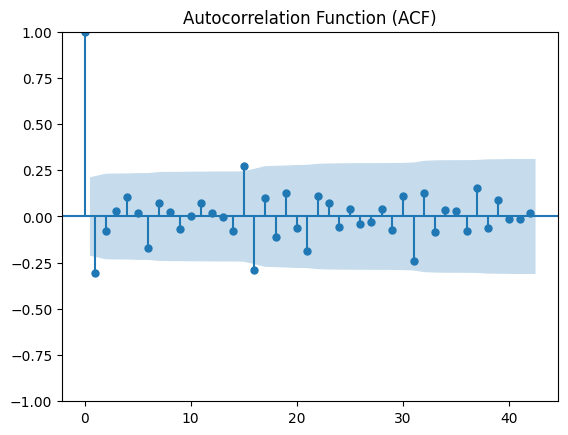

<Figure size 1200x600 with 0 Axes>

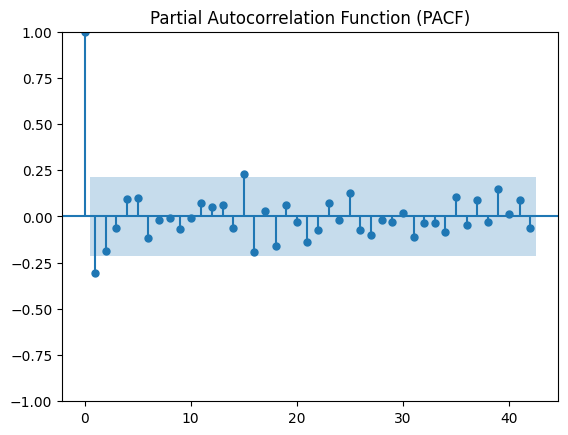


Fitting ARIMA model with order (5, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   86
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -341.277
Date:                Sat, 05 Apr 2025   AIC                            700.553
Time:                        14:38:11   BIC                            722.537
Sample:                             0   HQIC                           709.396
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2229      0.376      0.593      0.553      -0.513       0.959
ar.L2         -0.5894      0.316     -1.864      0.062      -1.209       0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

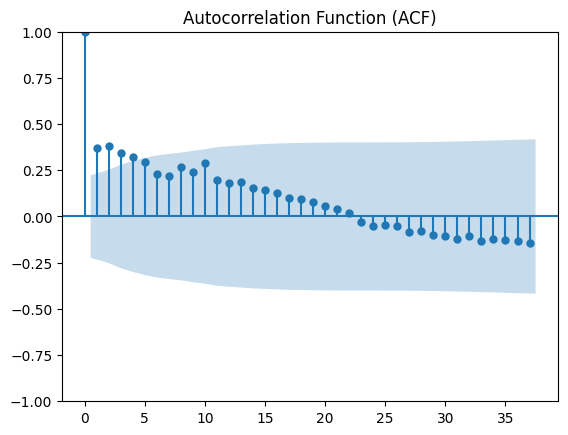

<Figure size 1200x600 with 0 Axes>

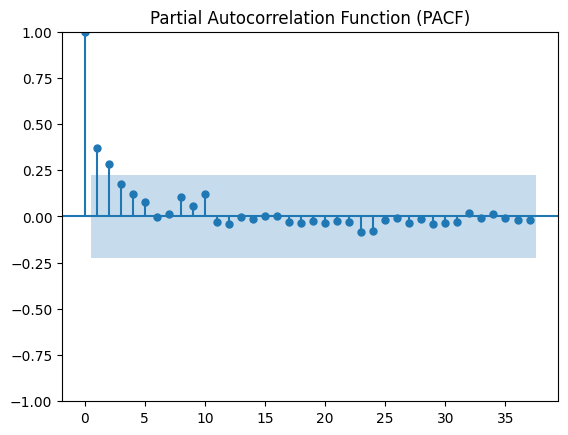


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   77
Model:                          ARIMA   Log Likelihood                -588.072
Date:                Sat, 05 Apr 2025   AIC                           1180.143
Time:                        14:38:11   BIC                           1184.831
Sample:                             0   HQIC                          1182.018
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4126.3912    110.284     37.416      0.000    3910.238    4342.544
sigma2       2.52e+05   1.76e+0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

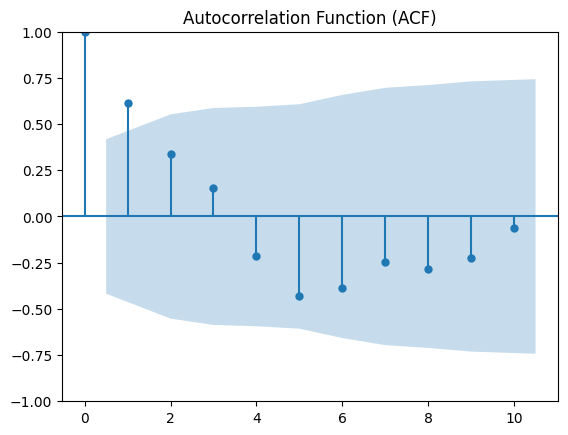

<Figure size 1200x600 with 0 Axes>

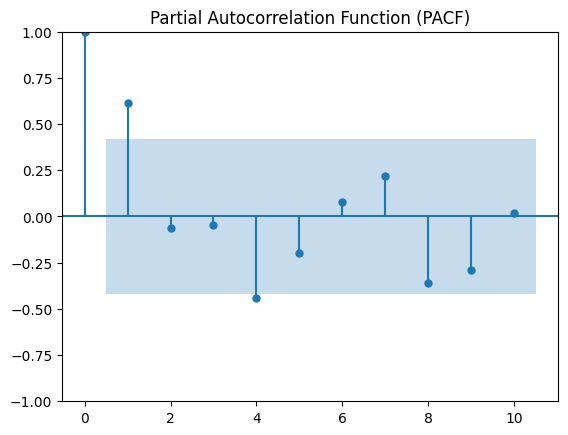


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   22
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -146.167
Date:                Sat, 05 Apr 2025   AIC                            308.334
Time:                        14:38:13   BIC                            317.063
Sample:                             0   HQIC                           310.391
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3274.1051     98.808     33.136      0.000    3080.446    3467.764
ar.L1          0.8131      0.319      2.546      0.011       0.187       1.4

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

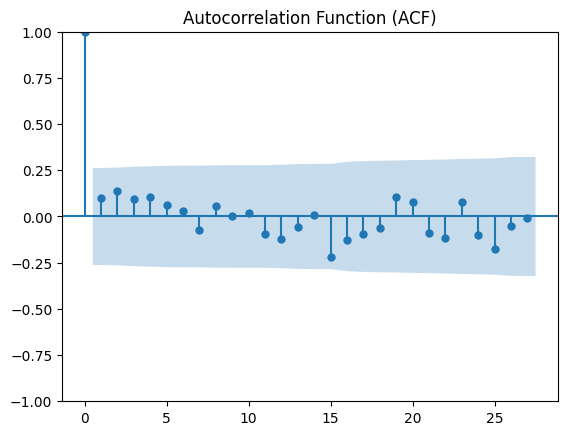

<Figure size 1200x600 with 0 Axes>

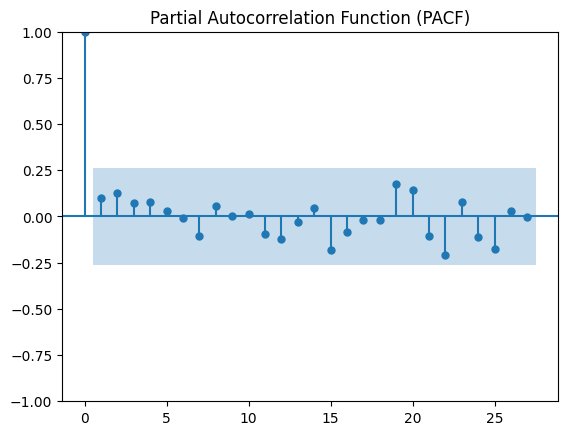


Fitting ARIMA model with order (2, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   56
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -375.373
Date:                Sat, 05 Apr 2025   AIC                            760.746
Time:                        14:38:15   BIC                            770.872
Sample:                             0   HQIC                           764.672
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1208.2912     55.758     21.670      0.000    1099.008    1317.575
ar.L1          0.7119      0.508      1.401      0.161      -0.284       1.7

<Figure size 1200x600 with 0 Axes>

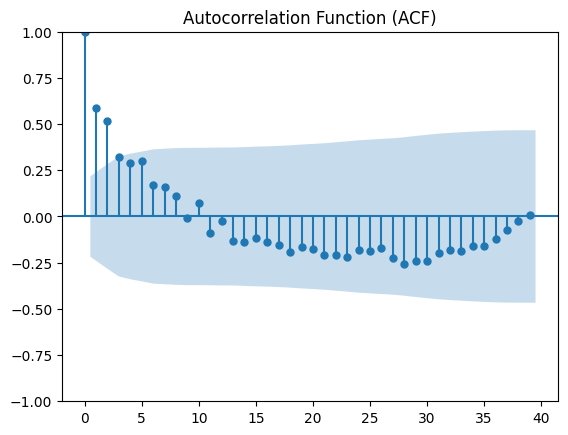

<Figure size 1200x600 with 0 Axes>

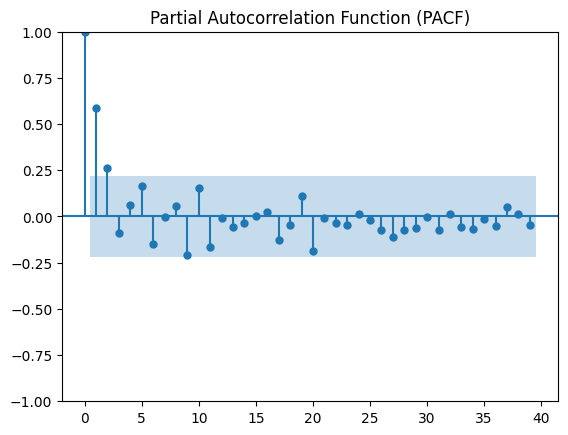


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -420.666
Date:                Sat, 05 Apr 2025   AIC                            853.331
Time:                        14:38:16   BIC                            867.698
Sample:                             0   HQIC                           859.095
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1472.7273     28.333     51.978      0.000    1417.195    1528.260
ar.L1          0.4559      0.174      2.622      0.009       0.115       0.7

<Figure size 1200x600 with 0 Axes>

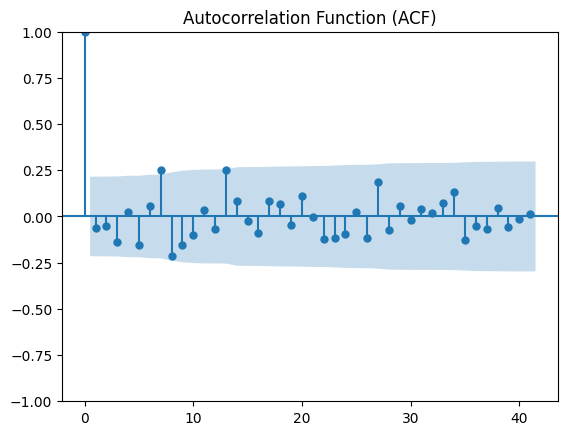

<Figure size 1200x600 with 0 Axes>

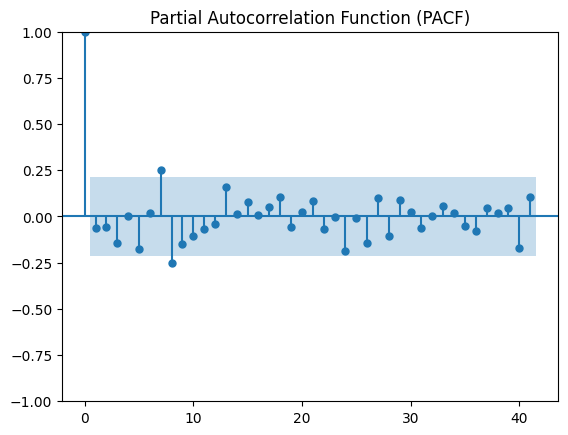


Fitting ARIMA model with order (5, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -553.376
Date:                Sat, 05 Apr 2025   AIC                           1126.752
Time:                        14:38:19   BIC                           1150.941
Sample:                             0   HQIC                          1136.470
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3590      0.261     -1.376      0.169      -0.870       0.152
ar.L2         -0.8994      0.206     -4.363      0.000      -1.304      -0.4

<Figure size 1200x600 with 0 Axes>

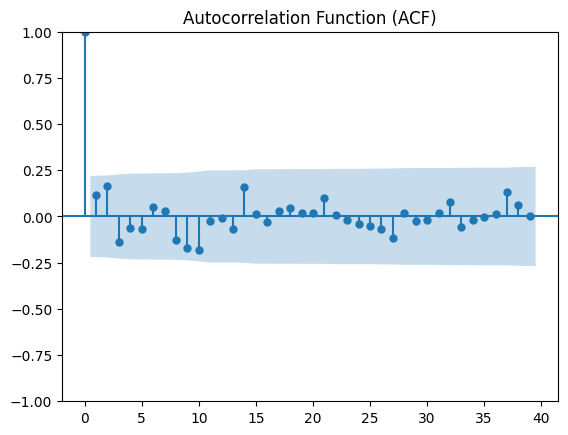

<Figure size 1200x600 with 0 Axes>

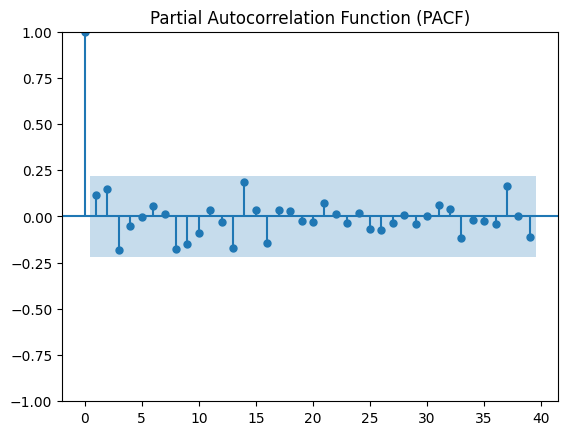


Fitting ARIMA model with order (5, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -398.602
Date:                Sat, 05 Apr 2025   AIC                            817.203
Time:                        14:38:21   BIC                            841.023
Sample:                             0   HQIC                           826.753
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4611      0.267     -1.726      0.084      -0.985       0.062
ar.L2         -0.0941      0.166     -0.566      0.572      -0.420       0.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

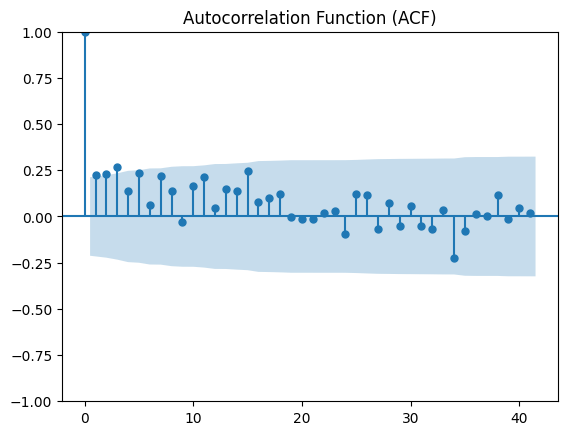

<Figure size 1200x600 with 0 Axes>

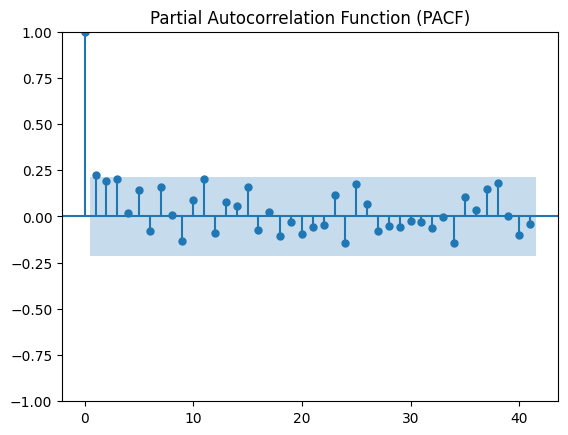


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -508.279
Date:                Sat, 05 Apr 2025   AIC                           1026.558
Time:                        14:38:22   BIC                           1038.771
Sample:                             0   HQIC                          1031.470
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1498.8424     27.795     53.924      0.000    1444.364    1553.321
ar.L1          0.1422      0.137      1.041      0.298      -0.126       0.4

<Figure size 1200x600 with 0 Axes>

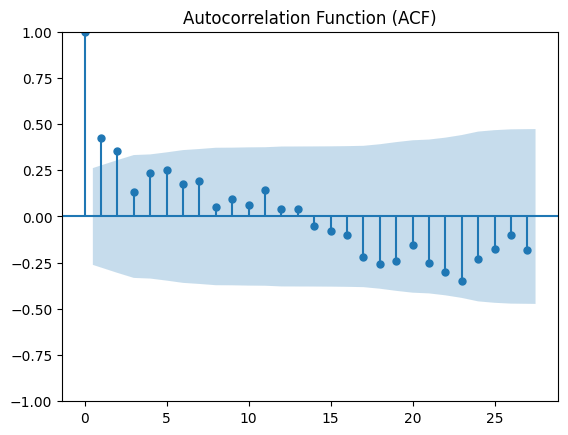

<Figure size 1200x600 with 0 Axes>

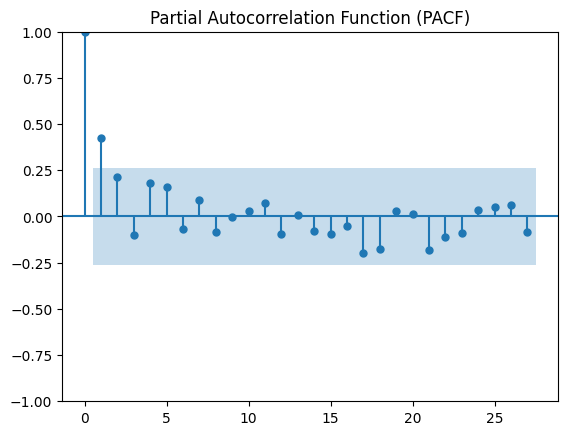


Fitting ARIMA model with order (2, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   56
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -372.502
Date:                Sat, 05 Apr 2025   AIC                            755.005
Time:                        14:38:23   BIC                            765.131
Sample:                             0   HQIC                           758.931
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        875.9463     69.026     12.690      0.000     740.658    1011.235
ar.L1         -0.0442      0.473     -0.093      0.926      -0.972       0.8

<Figure size 1200x600 with 0 Axes>

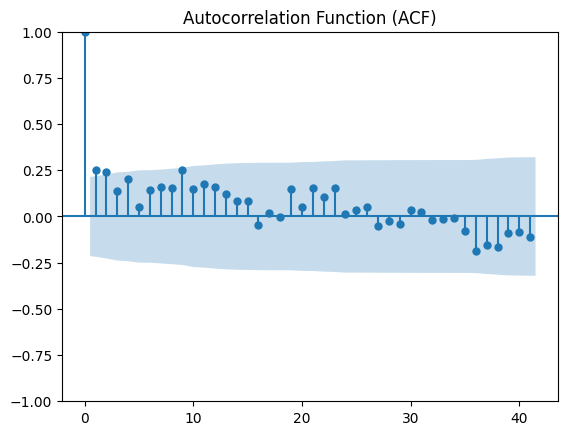

<Figure size 1200x600 with 0 Axes>

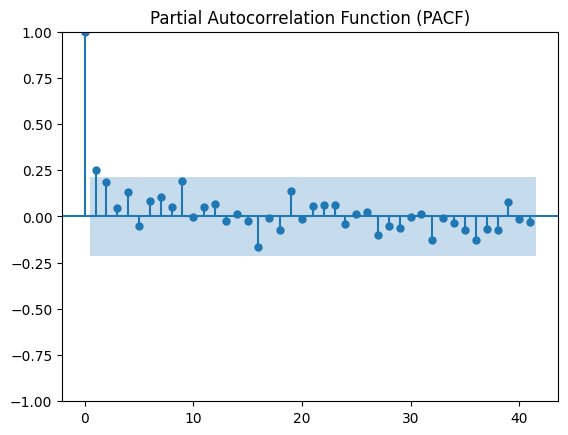


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   84
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -535.153
Date:                Sat, 05 Apr 2025   AIC                           1076.306
Time:                        14:38:24   BIC                           1083.599
Sample:                             0   HQIC                          1079.238
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1460.3392     26.801     54.489      0.000    1407.811    1512.867
ar.L1          0.3678      0.08

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

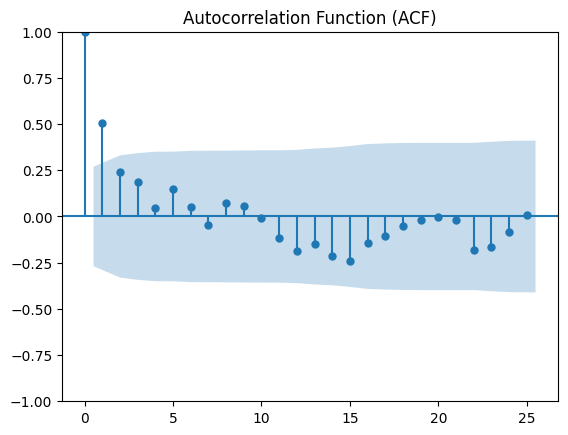

<Figure size 1200x600 with 0 Axes>

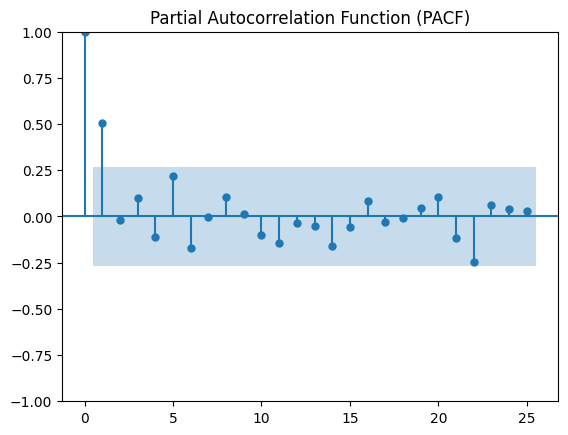


Fitting ARIMA model with order (3, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   53
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -314.557
Date:                Sat, 05 Apr 2025   AIC                            645.113
Time:                        14:38:25   BIC                            660.876
Sample:                             0   HQIC                           651.175
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1053.2479     31.113     33.853      0.000     992.268    1114.227
ar.L1         -0.7585      0.305     -2.489      0.013      -1.356      -0.1

<Figure size 1200x600 with 0 Axes>

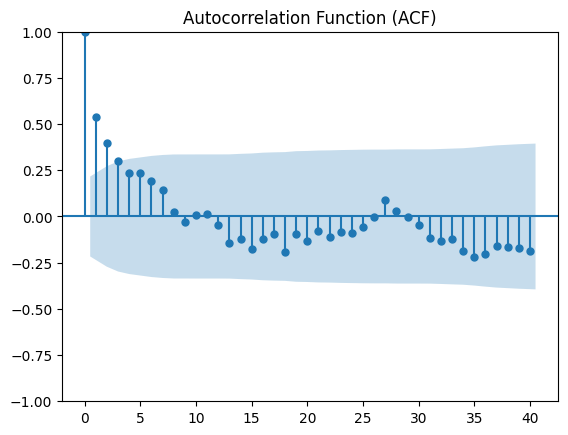

<Figure size 1200x600 with 0 Axes>

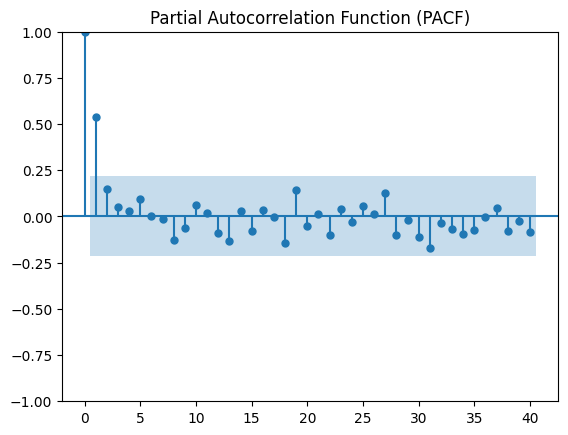


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -487.446
Date:                Sat, 05 Apr 2025   AIC                            988.892
Time:                        14:38:27   BIC                           1005.739
Sample:                             0   HQIC                           995.656
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        967.1703     31.624     30.584      0.000     905.189    1029.152
ar.L1         -0.1435      0.693     -0.207      0.836      -1.501       1.2

<Figure size 1200x600 with 0 Axes>

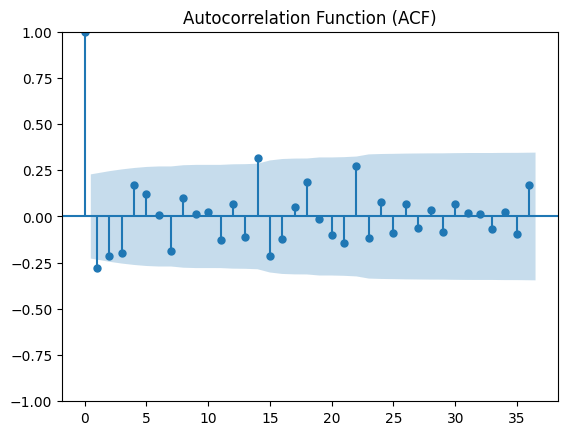

<Figure size 1200x600 with 0 Axes>

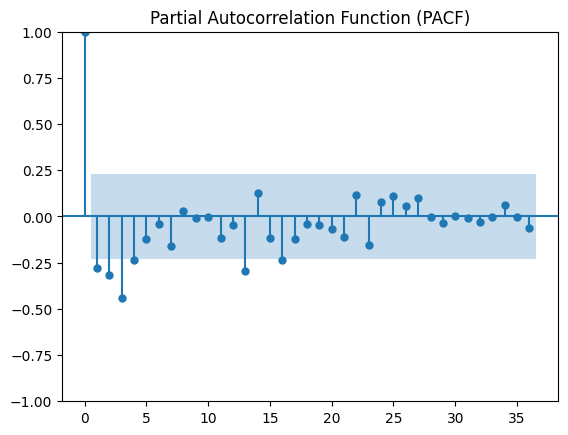


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   75
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -481.641
Date:                Sat, 05 Apr 2025   AIC                            985.282
Time:                        14:38:29   BIC                           1010.626
Sample:                             0   HQIC                           995.392
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0850      0.657     -0.129      0.897      -1.373       1.203
ar.L2         -0.6452      0.606     -1.064      0.287      -1.833       0.5

<Figure size 1200x600 with 0 Axes>

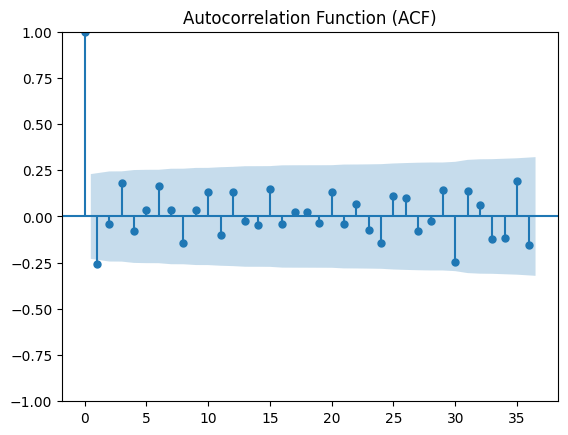

<Figure size 1200x600 with 0 Axes>

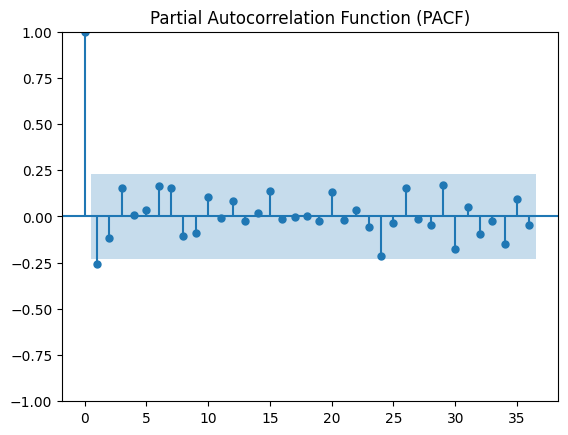


Fitting ARIMA model with order (3, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   74
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -427.296
Date:                Sat, 05 Apr 2025   AIC                            866.593
Time:                        14:38:31   BIC                            880.335
Sample:                             0   HQIC                           872.069
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2145      0.516      0.416      0.678      -0.797       1.226
ar.L2          0.3929      0.381      1.031      0.303      -0.354       1.1

<Figure size 1200x600 with 0 Axes>

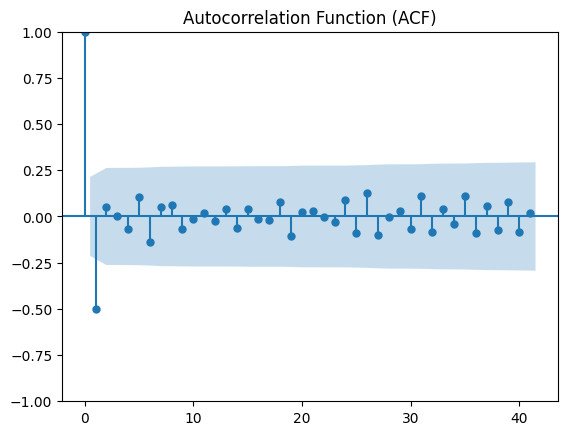

<Figure size 1200x600 with 0 Axes>

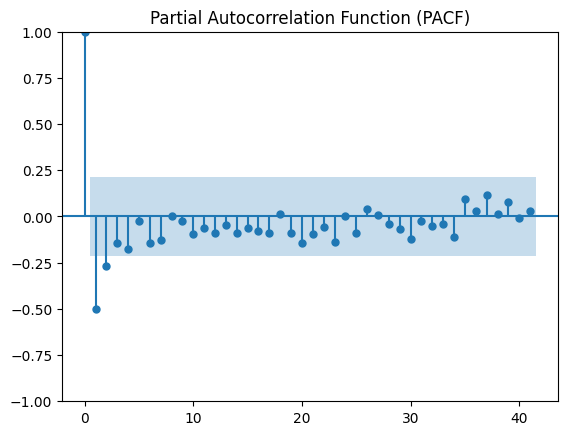


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   85
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -345.317
Date:                Sat, 05 Apr 2025   AIC                            700.633
Time:                        14:38:32   BIC                            712.787
Sample:                             0   HQIC                           705.519
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9906      0.166     -5.953      0.000      -1.317      -0.664
ar.L2         -0.0341      0.148     -0.230      0.818      -0.325       0.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

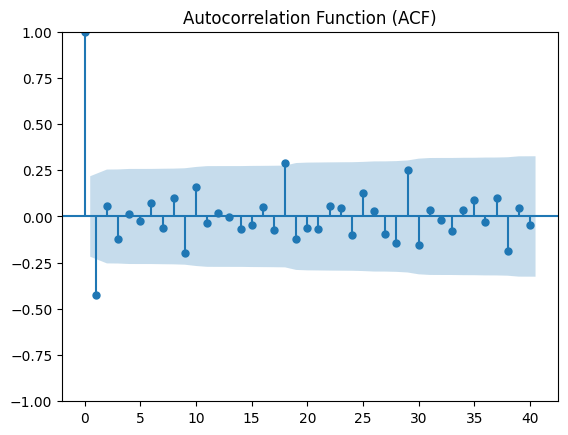

<Figure size 1200x600 with 0 Axes>

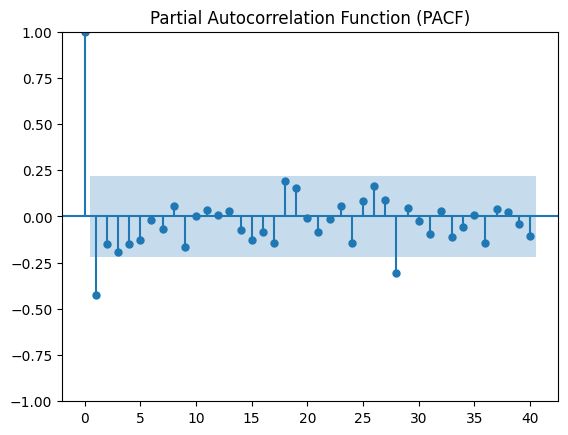


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -528.211
Date:                Sat, 05 Apr 2025   AIC                           1066.421
Time:                        14:38:34   BIC                           1078.394
Sample:                             0   HQIC                          1071.225
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4502      0.311     -1.447      0.148      -1.060       0.160
ar.L2          0.4242      0.204      2.075      0.038       0.023       0.8

<Figure size 1200x600 with 0 Axes>

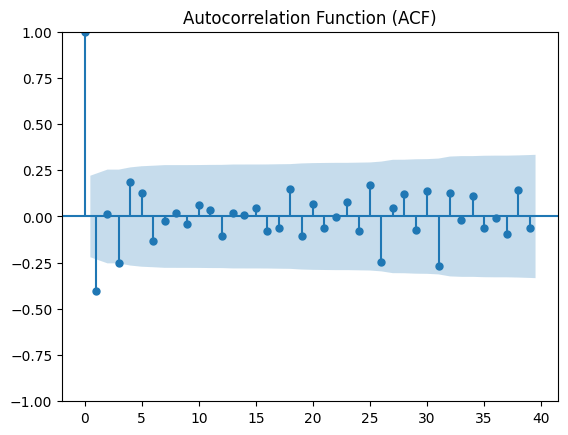

<Figure size 1200x600 with 0 Axes>

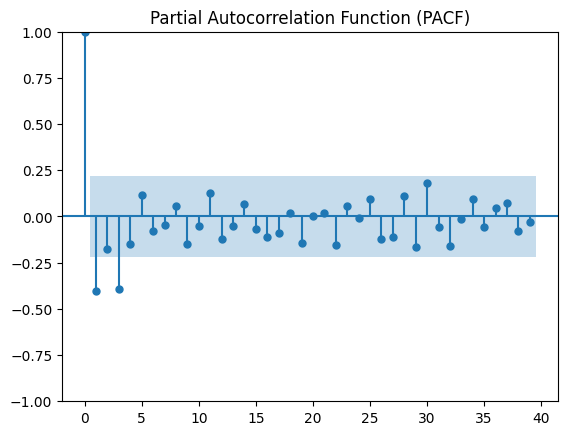


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -477.294
Date:                Sat, 05 Apr 2025   AIC                            964.588
Time:                        14:38:35   BIC                            976.435
Sample:                             0   HQIC                           969.334
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8649      0.189     -4.577      0.000      -1.235      -0.495
ar.L2          0.1349      0.166      0.810      0.418      -0.191       0.4

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

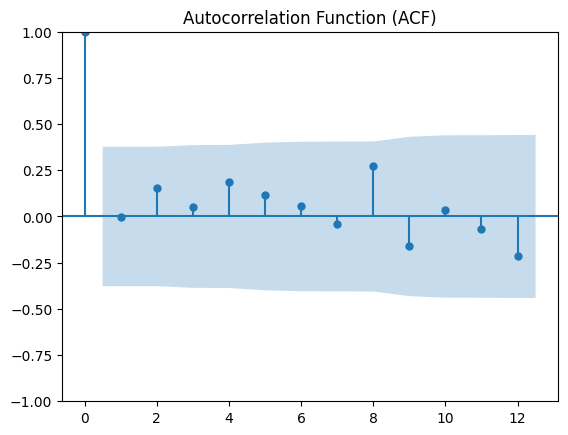

<Figure size 1200x600 with 0 Axes>

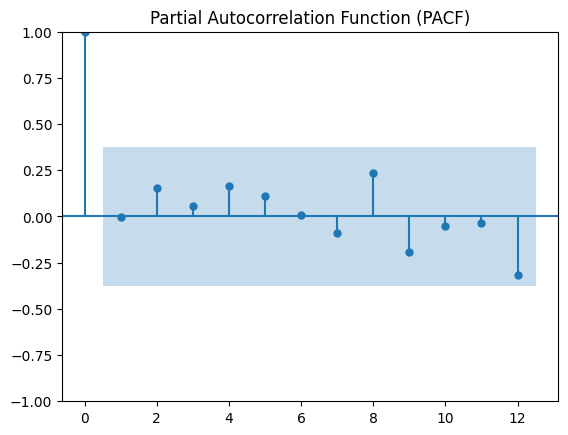


Fitting ARIMA model with order (2, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   27
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -193.854
Date:                Sat, 05 Apr 2025   AIC                            395.707
Time:                        14:38:37   BIC                            400.890
Sample:                             0   HQIC                           397.248
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1707.0399     78.139     21.846      0.000    1553.891    1860.189
ar.L1         -0.0227      0.233     -0.098      0.922      -0.479       0.4

<Figure size 1200x600 with 0 Axes>

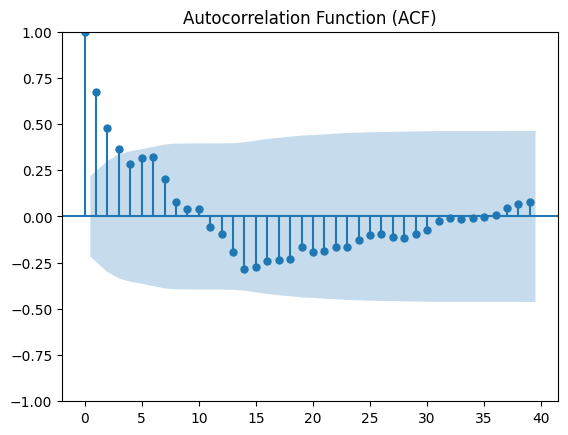

<Figure size 1200x600 with 0 Axes>

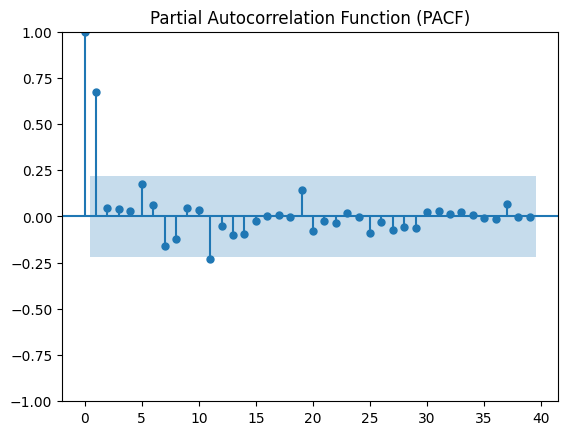


Fitting ARIMA model with order (5, 0, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -469.176
Date:                Sat, 05 Apr 2025   AIC                            962.353
Time:                        14:38:39   BIC                            991.086
Sample:                             0   HQIC                           973.881
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1516.5738     60.847     24.924      0.000    1397.316    1635.832
ar.L1          2.6478      1.824      1.452      0.147      -0.927       6.2

<Figure size 1200x600 with 0 Axes>

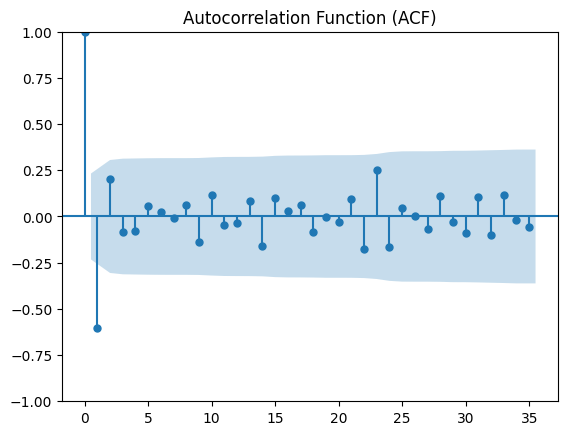

<Figure size 1200x600 with 0 Axes>

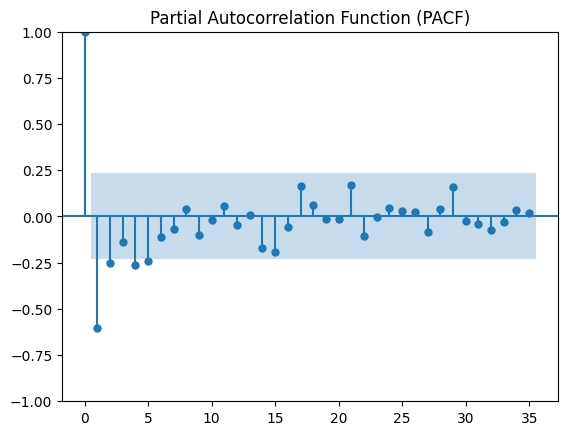


Fitting ARIMA model with order (1, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -380.957
Date:                Sat, 05 Apr 2025   AIC                            767.914
Time:                        14:38:40   BIC                            774.702
Sample:                             0   HQIC                           770.614
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1831      0.113     -1.626      0.104      -0.404       0.038
ma.L1         -0.8027      0.086     -9.355      0.000      -0.971      -0.6

<Figure size 1200x600 with 0 Axes>

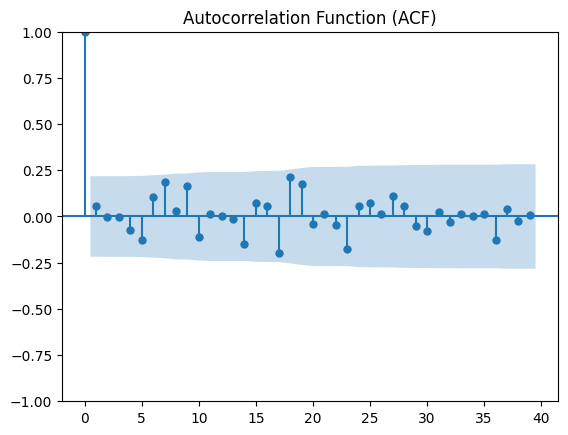

<Figure size 1200x600 with 0 Axes>

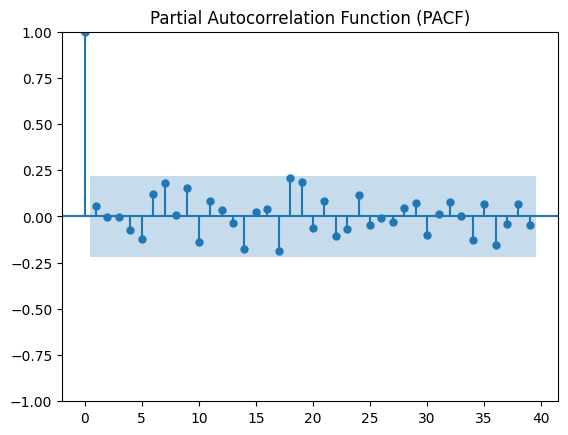


Fitting ARIMA model with order (4, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   81
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -523.711
Date:                Sat, 05 Apr 2025   AIC                           1065.423
Time:                        14:38:42   BIC                           1086.973
Sample:                             0   HQIC                          1074.069
                                 - 81                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        748.5726     20.966     35.704      0.000     707.480     789.665
ar.L1          0.7846      1.098      0.714      0.475      -1.368       2.9

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

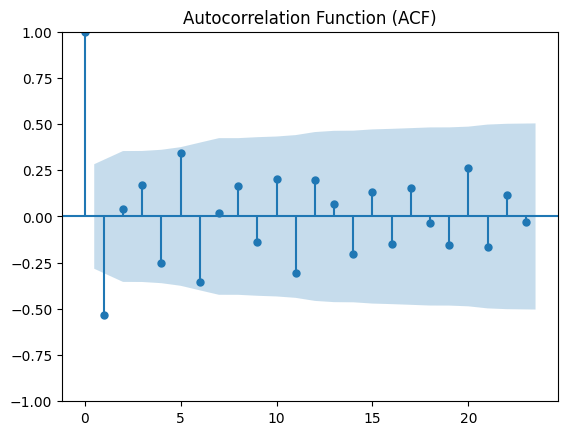

<Figure size 1200x600 with 0 Axes>

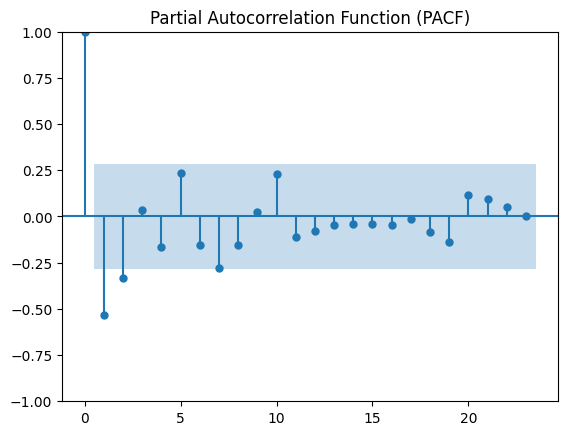


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   49
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -248.589
Date:                Sat, 05 Apr 2025   AIC                            515.179
Time:                        14:38:44   BIC                            532.020
Sample:                             0   HQIC                           521.543
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1217      0.472      0.258      0.796      -0.803       1.046
ar.L2          0.0526      0.489      0.108      0.914      -0.907       1.0

<Figure size 1200x600 with 0 Axes>

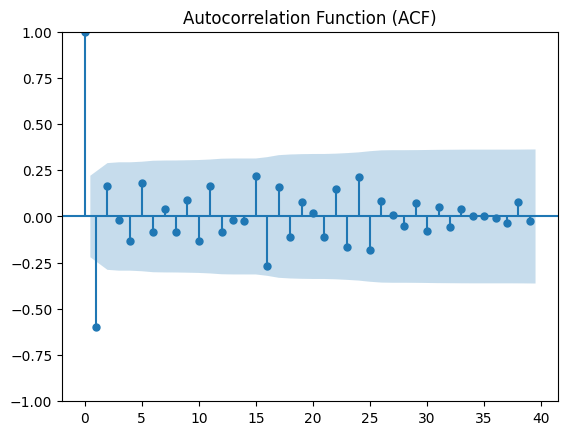

<Figure size 1200x600 with 0 Axes>

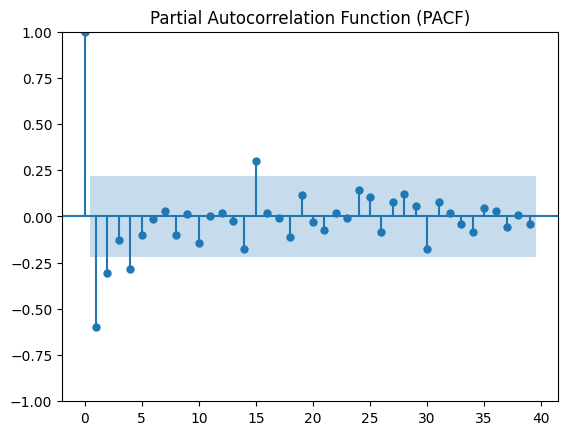


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -488.626
Date:                Sat, 05 Apr 2025   AIC                            987.253
Time:                        14:38:45   BIC                            999.100
Sample:                             0   HQIC                           991.999
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0550      1.972     -0.028      0.978      -3.920       3.810
ar.L2          0.1332      0.405      0.329      0.742      -0.660       0.9

<Figure size 1200x600 with 0 Axes>

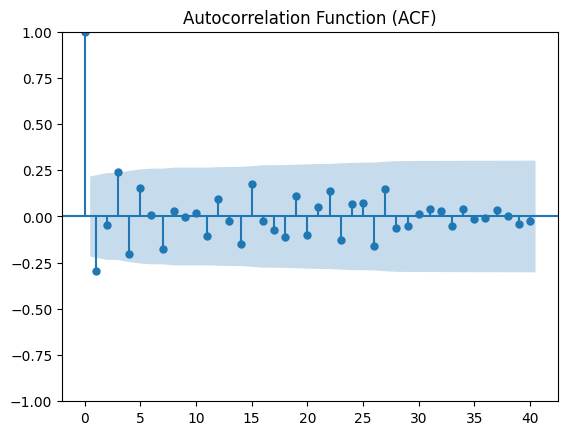

<Figure size 1200x600 with 0 Axes>

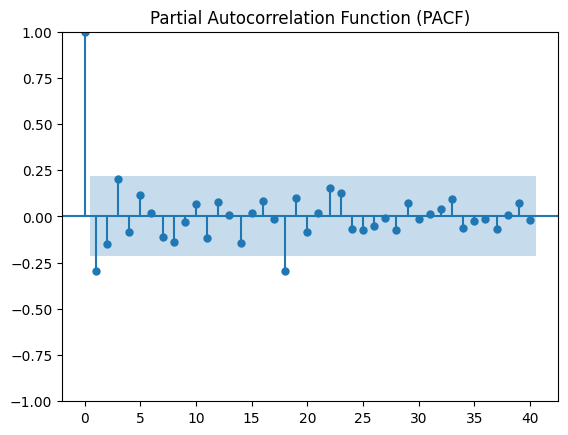


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -378.341
Date:                Sat, 05 Apr 2025   AIC                            774.682
Time:                        14:38:49   BIC                            796.342
Sample:                             0   HQIC                           783.378
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1828      0.333      0.548      0.584      -0.471       0.836
ar.L2          0.1371      0.306      0.448      0.654      -0.463       0.7

<Figure size 1200x600 with 0 Axes>

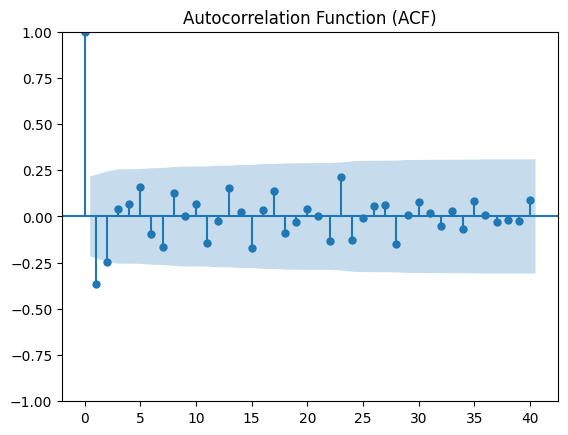

<Figure size 1200x600 with 0 Axes>

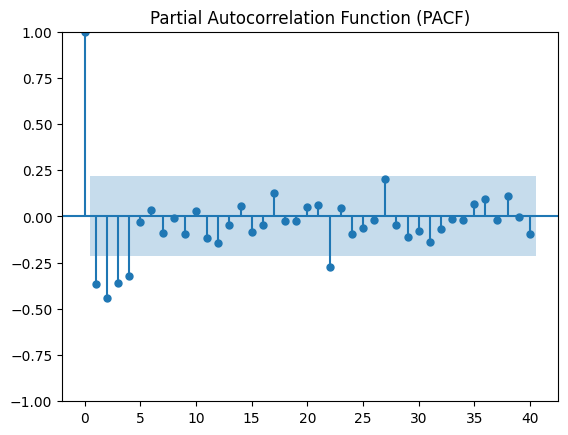


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -536.374
Date:                Sat, 05 Apr 2025   AIC                           1094.749
Time:                        14:38:53   BIC                           1121.223
Sample:                             0   HQIC                          1105.378
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7548      0.440     -3.987      0.000      -2.617      -0.892
ar.L2         -1.6281      0.761     -2.139      0.032      -3.120      -0.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

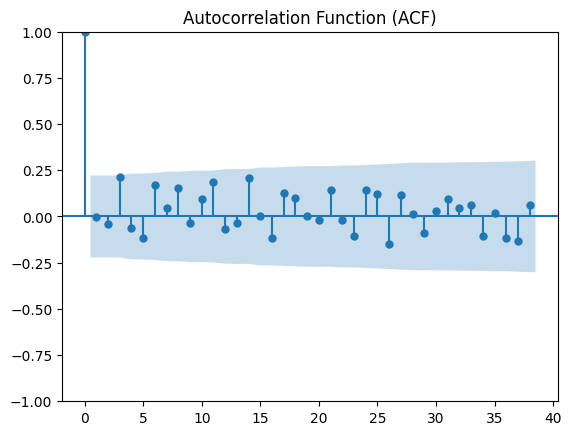

<Figure size 1200x600 with 0 Axes>

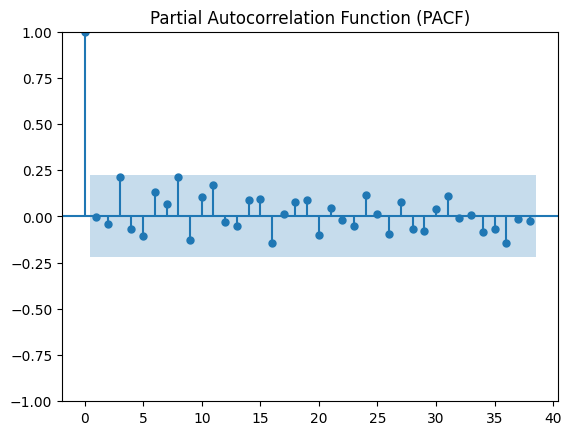


Fitting ARIMA model with order (3, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   78
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -584.401
Date:                Sat, 05 Apr 2025   AIC                           1180.801
Time:                        14:38:54   BIC                           1194.941
Sample:                             0   HQIC                          1186.462
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1415.4488     67.012     21.122      0.000    1284.108    1546.790
ar.L1         -0.1310      0.543     -0.241      0.809      -1.196       0.9

<Figure size 1200x600 with 0 Axes>

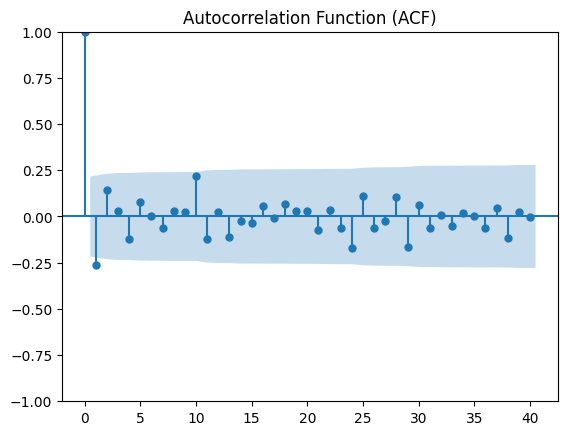

<Figure size 1200x600 with 0 Axes>

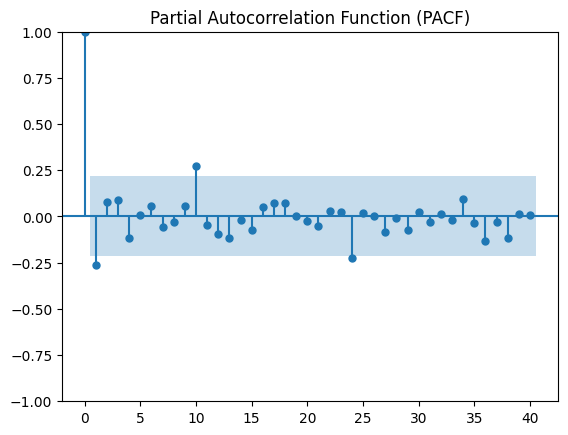


Fitting ARIMA model with order (4, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -314.324
Date:                Sat, 05 Apr 2025   AIC                            642.647
Time:                        14:38:55   BIC                            659.494
Sample:                             0   HQIC                           649.411
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3043      0.136     -2.234      0.026      -0.571      -0.037
ar.L2         -0.7489      0.177     -4.243      0.000      -1.095      -0.4

<Figure size 1200x600 with 0 Axes>

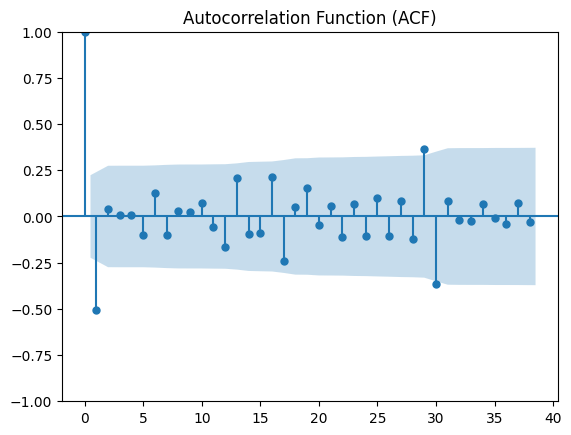

<Figure size 1200x600 with 0 Axes>

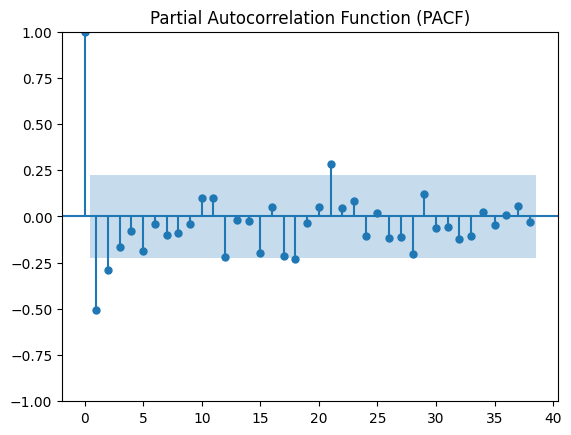


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   78
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -402.884
Date:                Sat, 05 Apr 2025   AIC                            819.767
Time:                        14:38:59   BIC                            836.174
Sample:                             0   HQIC                           826.330
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4644      0.254     -1.827      0.068      -0.963       0.034
ar.L2         -0.8621      0.308     -2.795      0.005      -1.467      -0.2

<Figure size 1200x600 with 0 Axes>

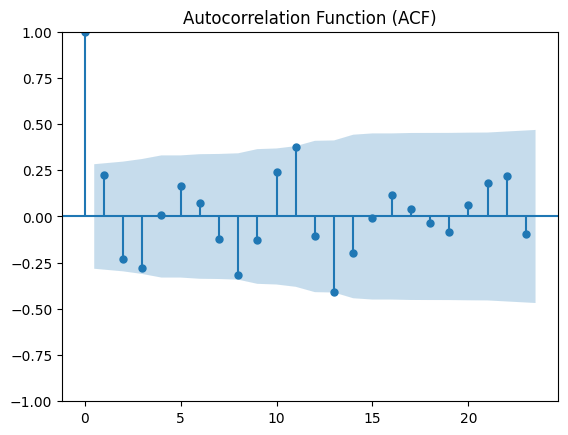

<Figure size 1200x600 with 0 Axes>

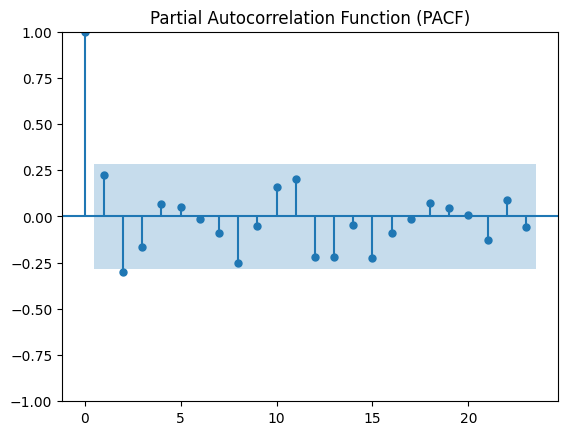


Fitting ARIMA model with order (4, 0, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   48
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -374.672
Date:                Sat, 05 Apr 2025   AIC                            769.345
Time:                        14:39:03   BIC                            788.057
Sample:                             0   HQIC                           776.416
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1355.8310     39.615     34.225      0.000    1278.188    1433.474
ar.L1          1.3127      0.660      1.988      0.047       0.019       2.6

<Figure size 1200x600 with 0 Axes>

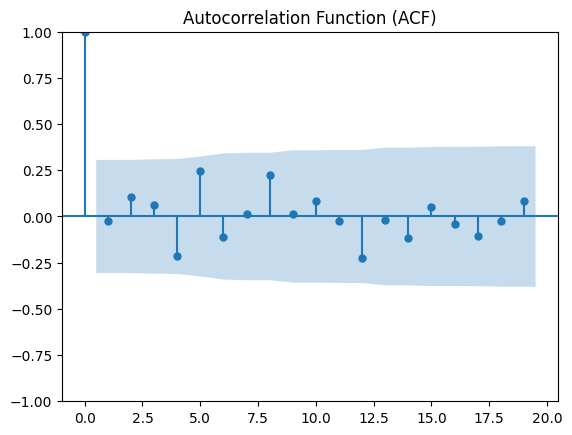

<Figure size 1200x600 with 0 Axes>

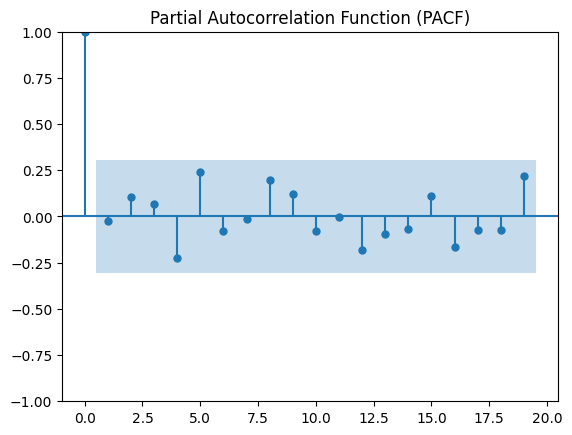


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   41
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -255.617
Date:                Sat, 05 Apr 2025   AIC                            525.234
Time:                        14:39:05   BIC                            537.229
Sample:                             0   HQIC                           529.602
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        953.6826     39.643     24.057      0.000     875.983    1031.382
ar.L1         -1.0990      0.329     -3.341      0.001      -1.744      -0.4

<Figure size 1200x600 with 0 Axes>

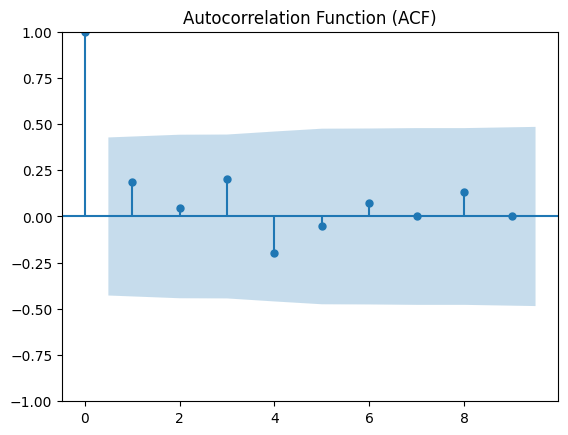

<Figure size 1200x600 with 0 Axes>

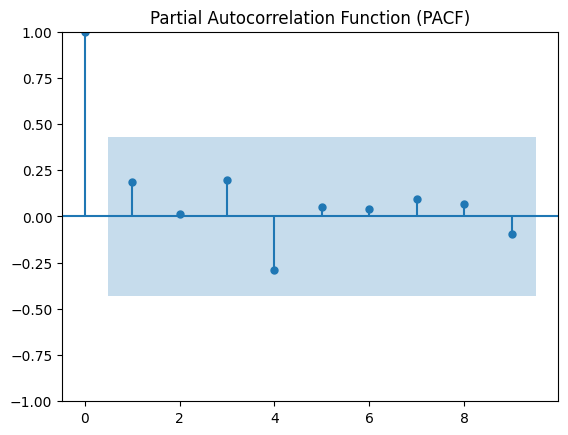


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -162.204
Date:                Sat, 05 Apr 2025   AIC                            332.409
Time:                        14:39:06   BIC                            336.587
Sample:                             0   HQIC                           333.315
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4276.9045    190.734     22.423      0.000    3903.072    4650.737
ar.L1         -0.5479      0.762     -0.719      0.472      -2.042       0.9

<Figure size 1200x600 with 0 Axes>

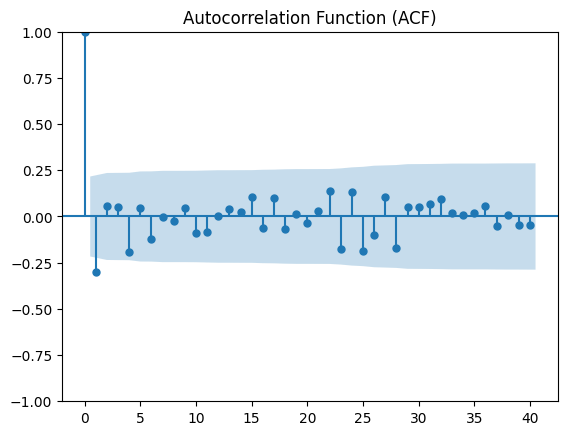

<Figure size 1200x600 with 0 Axes>

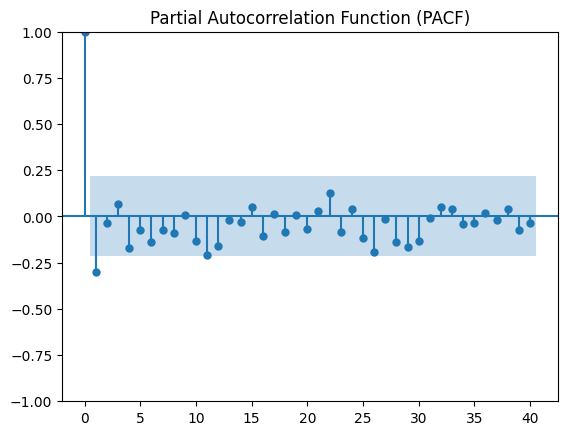


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   83
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -400.153
Date:                Sat, 05 Apr 2025   AIC                            814.306
Time:                        14:39:07   BIC                            831.153
Sample:                             0   HQIC                           821.069
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6481      0.625     -1.036      0.300      -1.874       0.578
ar.L2          0.5099      0.639      0.798      0.425      -0.742       1.7

<Figure size 1200x600 with 0 Axes>

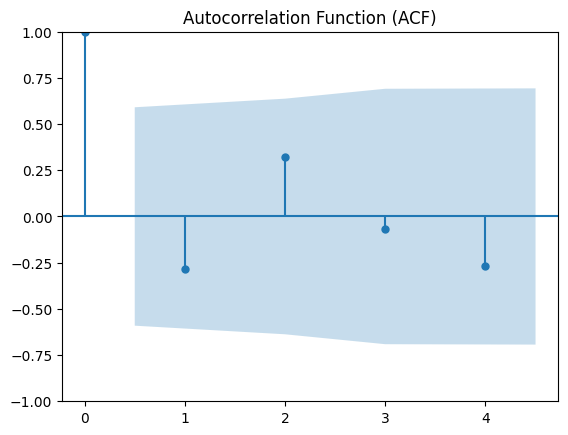

<Figure size 1200x600 with 0 Axes>

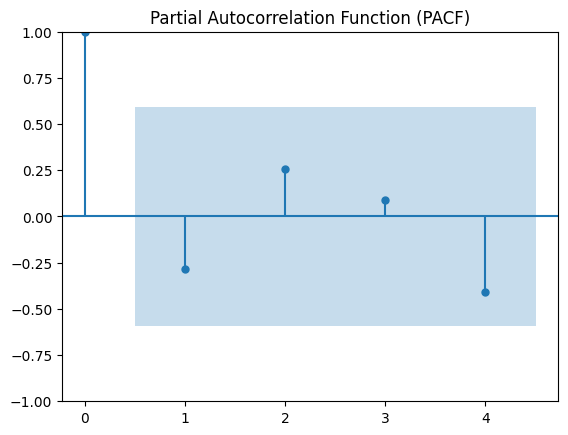


Fitting ARIMA model with order (2, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   11
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -82.414
Date:                Sat, 05 Apr 2025   AIC                            172.827
Time:                        14:39:08   BIC                            174.419
Sample:                             0   HQIC                           171.824
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1135.2243    274.422      4.137      0.000     597.367    1673.082
ar.L1         -0.3325      0.442     -0.752      0.452      -1.200       0.5

<Figure size 1200x600 with 0 Axes>

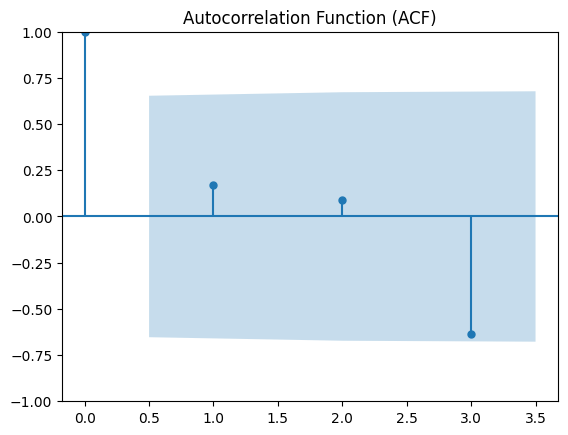

<Figure size 1200x600 with 0 Axes>

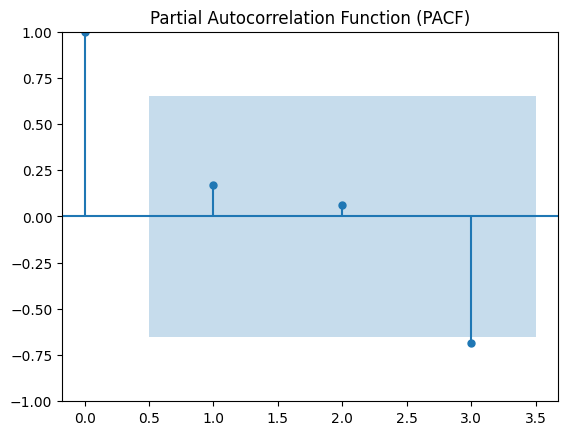


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    9
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -55.491
Date:                Sat, 05 Apr 2025   AIC                            118.982
Time:                        14:39:10   BIC                            119.771
Sample:                             0   HQIC                           117.279
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        777.4297    105.565      7.364      0.000     570.526     984.334
ar.L1          0.2288      3.900      0.059      0.953      -7.415       7.8

<Figure size 1200x600 with 0 Axes>

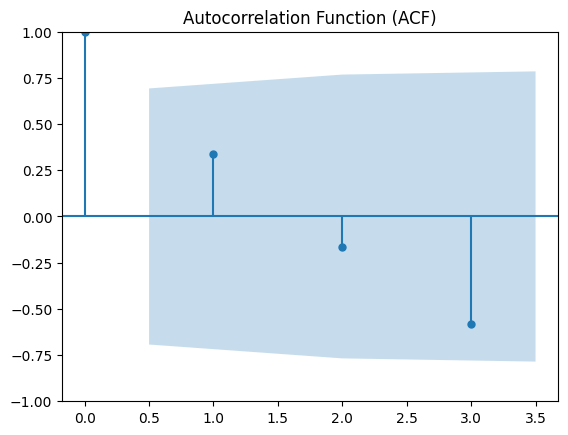

<Figure size 1200x600 with 0 Axes>

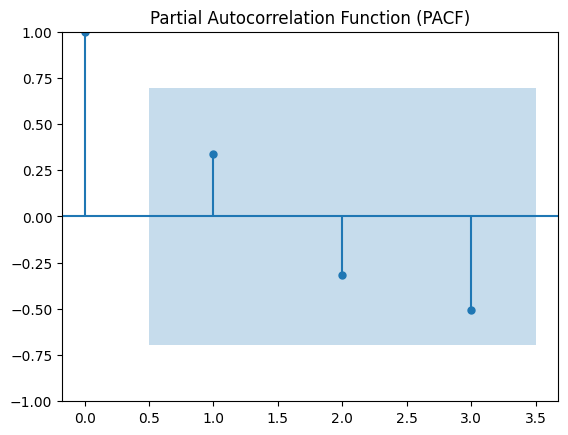


Fitting ARIMA model with order (2, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    8
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -43.398
Date:                Sat, 05 Apr 2025   AIC                             96.796
Time:                        14:39:14   BIC                             97.193
Sample:                             0   HQIC                            94.117
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1210.5391     12.571     96.294      0.000    1185.900    1235.178
ar.L1          1.0362      0.396      2.618      0.009       0.261       1.8

<Figure size 1200x600 with 0 Axes>

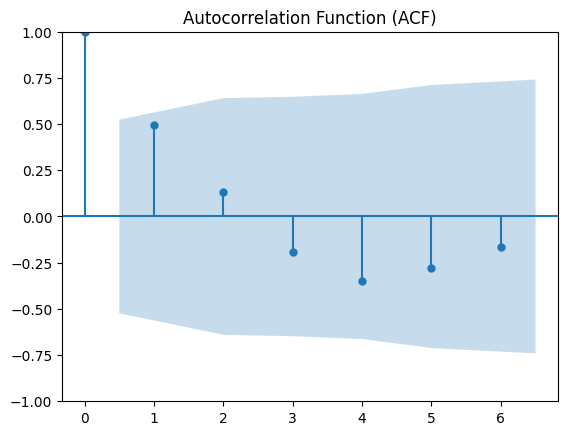

<Figure size 1200x600 with 0 Axes>

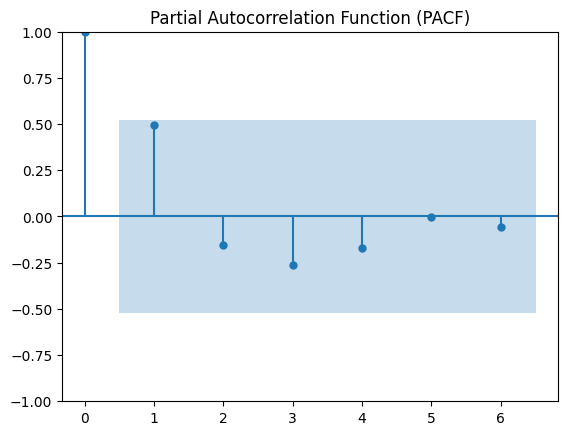


Fitting ARIMA model with order (2, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   14
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -98.407
Date:                Sat, 05 Apr 2025   AIC                            206.814
Time:                        14:39:17   BIC                            210.009
Sample:                             0   HQIC                           206.518
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        707.2756     58.862     12.016      0.000     591.908     822.643
ar.L1          1.3483      0.230      5.851      0.000       0.897       1.8

<Figure size 1200x600 with 0 Axes>

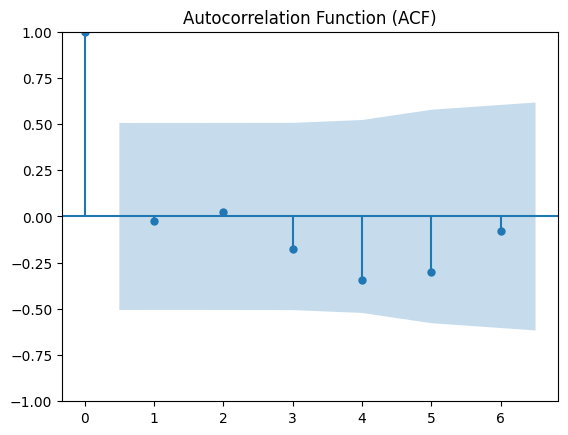

<Figure size 1200x600 with 0 Axes>

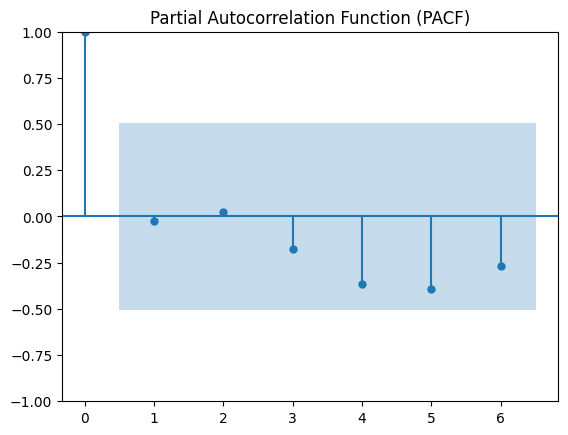


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   15
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -109.493
Date:                Sat, 05 Apr 2025   AIC                            232.986
Time:                        14:39:19   BIC                            237.942
Sample:                             0   HQIC                           232.933
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1585.6081     10.363    153.013      0.000    1565.298    1605.918
ar.L1          0.8861      0.681      1.301      0.193      -0.449       2.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

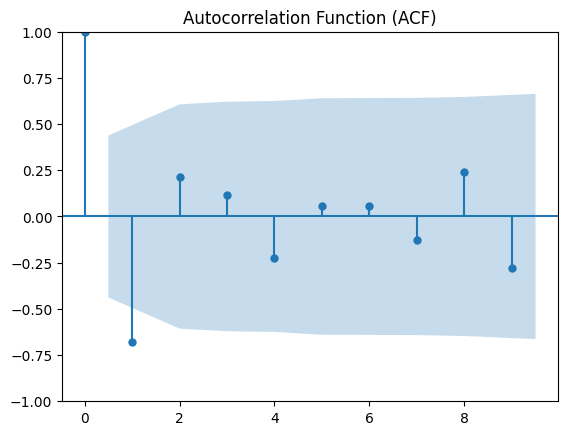

<Figure size 1200x600 with 0 Axes>

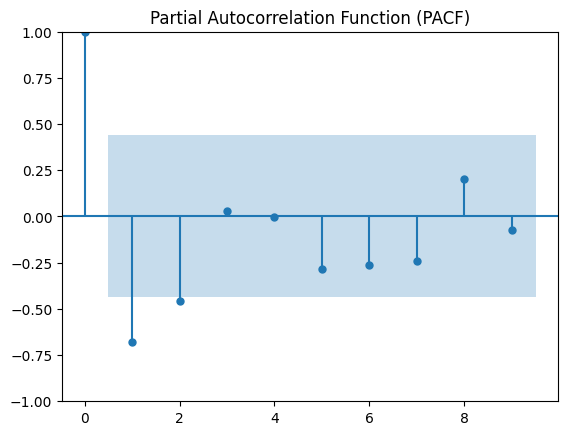


Fitting ARIMA model with order (5, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   21
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -130.774
Date:                Sat, 05 Apr 2025   AIC                            275.549
Time:                        14:39:20   BIC                            282.519
Sample:                             0   HQIC                           276.909
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6101      0.410     -1.488      0.137      -1.414       0.194
ar.L2         -0.0152      0.564     -0.027      0.978      -1.120       1.0

<Figure size 1200x600 with 0 Axes>

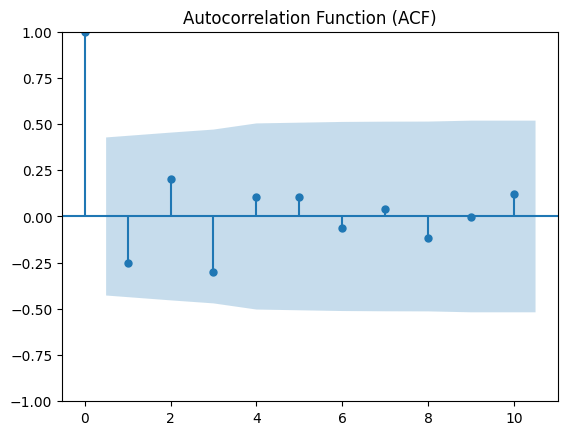

<Figure size 1200x600 with 0 Axes>

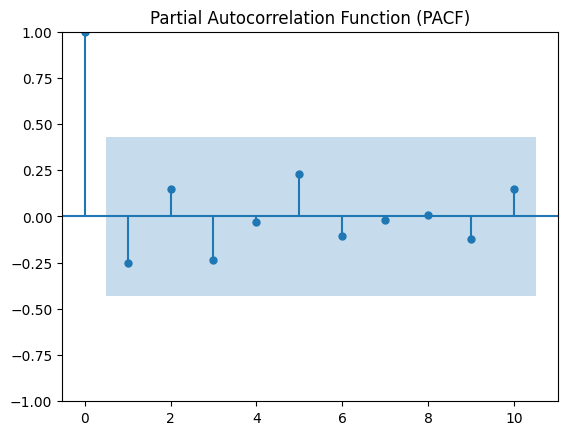


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   22
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -169.451
Date:                Sat, 05 Apr 2025   AIC                            352.902
Time:                        14:39:21   BIC                            360.214
Sample:                             0   HQIC                           354.489
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0413      0.689      0.060      0.952      -1.310       1.392
ar.L2         -0.5373      0.461     -1.167      0.243      -1.440       0.3

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

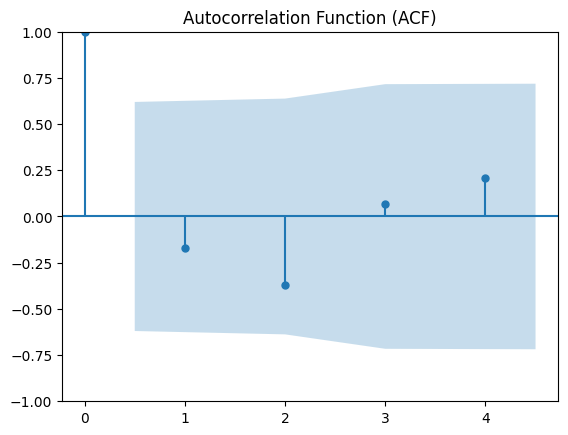

<Figure size 1200x600 with 0 Axes>

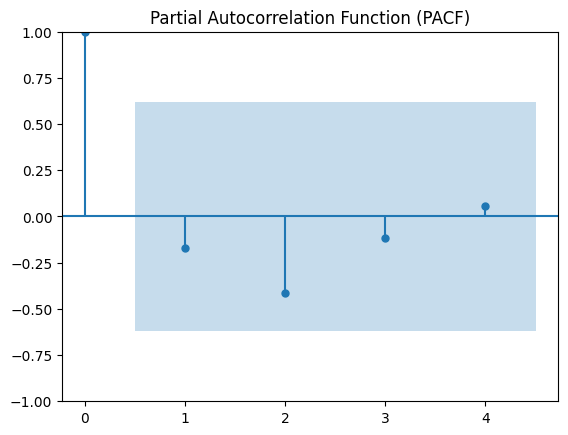


Fitting ARIMA model with order (1, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -57.259
Date:                Sat, 05 Apr 2025   AIC                            122.518
Time:                        14:39:23   BIC                            123.728
Sample:                             0   HQIC                           121.190
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1214.0903     30.728     39.511      0.000    1153.865    1274.316
ar.L1          0.3975      0.589      0.675      0.500      -0.757       1.5

<Figure size 1200x600 with 0 Axes>

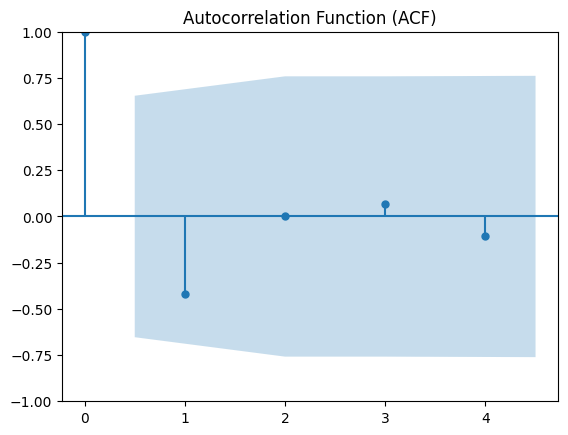

<Figure size 1200x600 with 0 Axes>

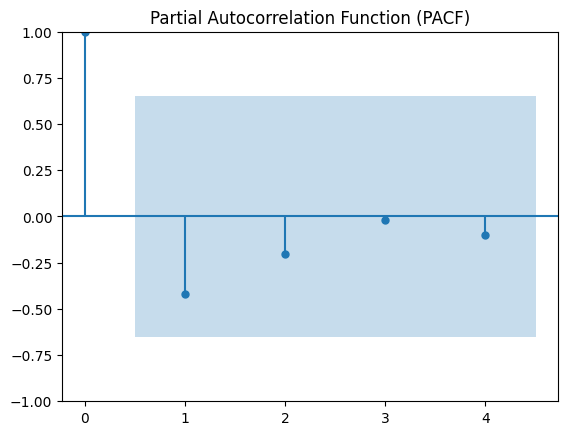


Fitting ARIMA model with order (1, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -63.333
Date:                Sat, 05 Apr 2025   AIC                            132.665
Time:                        14:39:25   BIC                            133.257
Sample:                             0   HQIC                           131.388
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7036      0.463     -1.519      0.129      -1.611       0.204
ma.L1          0.0793      1.008      0.079      0.937      -1.896       2.0

<Figure size 1200x600 with 0 Axes>

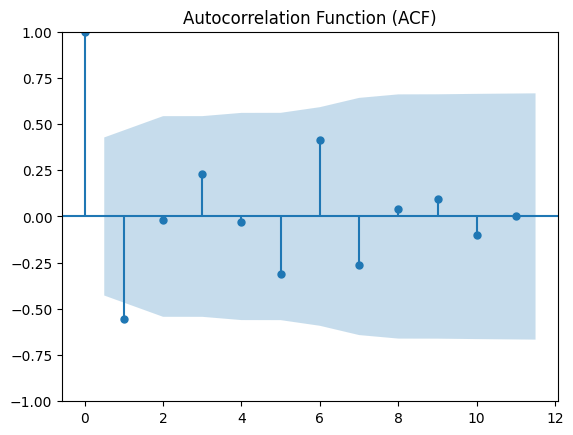

Can't plot the acf/pacf plots for નવા ધાણા due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 11 must be < 10.

Fitting ARIMA model with order (3, 3, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 3, 2)   Log Likelihood                -163.805
Date:                Sat, 05 Apr 2025   AIC                            339.609
Time:                        14:39:26   BIC                            345.877
Sample:                             0   HQIC                           340.970
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0284    235.910     -0.004      0.997    -463.403     461.347
ar.L2         -0.0507      6.632     -0.008      0.994     -13.050      12.9

<Figure size 1200x600 with 0 Axes>

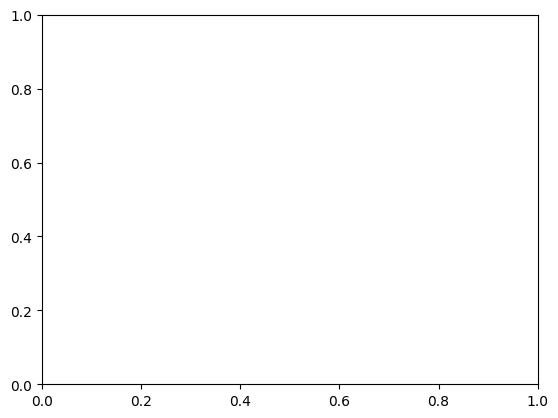

<Figure size 1200x600 with 0 Axes>

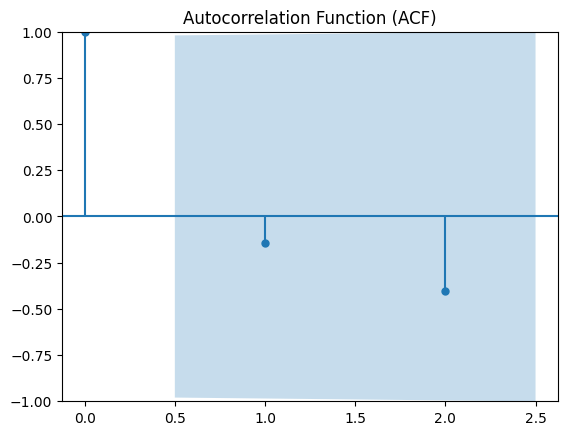

<Figure size 1200x600 with 0 Axes>

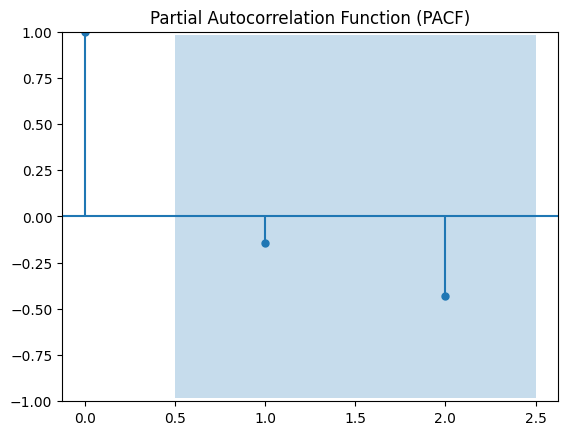


Fitting ARIMA model with order (0, 3, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(0, 3, 0)   Log Likelihood                 -33.501
Date:                Sat, 05 Apr 2025   AIC                             69.003
Time:                        14:39:27   BIC                             68.389
Sample:                             0   HQIC                            67.656
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.099e+06   8.95e+05      1.228      0.219   -6.55e+05    2.85e+06
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

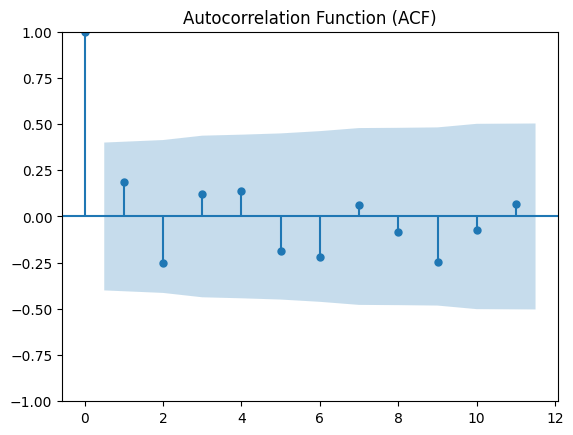

<Figure size 1200x600 with 0 Axes>

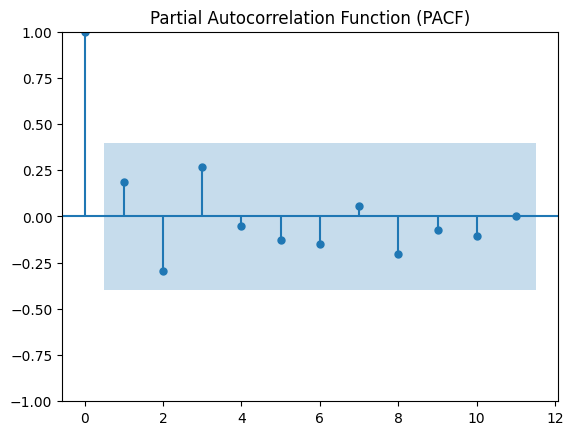


Fitting ARIMA model with order (4, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -174.034
Date:                Sat, 05 Apr 2025   AIC                            364.069
Time:                        14:39:31   BIC                            373.493
Sample:                             0   HQIC                           366.569
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2290.9421    117.044     19.573      0.000    2061.540    2520.344
ar.L1          0.7153      0.299      2.391      0.017       0.129       1.3

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

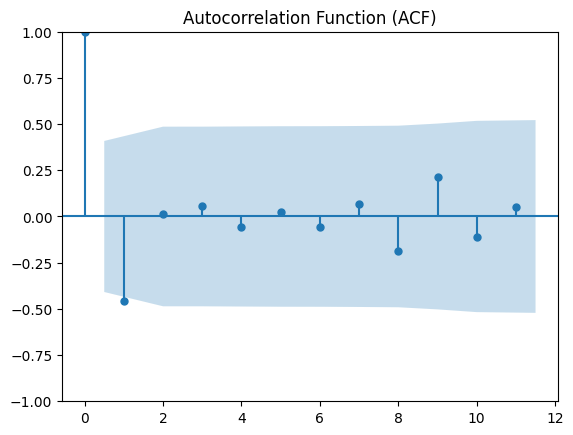

<Figure size 1200x600 with 0 Axes>

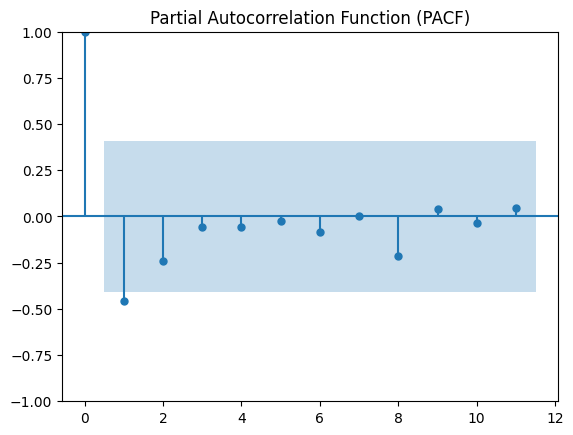


Fitting ARIMA model with order (3, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   24
Model:                 ARIMA(3, 1, 1)   Log Likelihood                   0.000
Date:                Sat, 05 Apr 2025   AIC                             10.000
Time:                        14:39:31   BIC                             15.677
Sample:                             0   HQIC                            11.428
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   6.28e-07  -1.59e+06      0.000      -1.000      -1.000
ar.L2          1.0000        na

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for નવું લસણ saved as D:\APMC-price-predictor\ml_models\commodities_saved_models\arima_model_fd8740eeef51975fce673af58100e1dc.pkl
નવું જીરૂ size:  17
True
Checking stationarity for the raw price data of નવું જીરૂ:
Stationarity cannot be applicable for નવું જીરૂ
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 0 at lags []


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


<Figure size 1200x600 with 0 Axes>

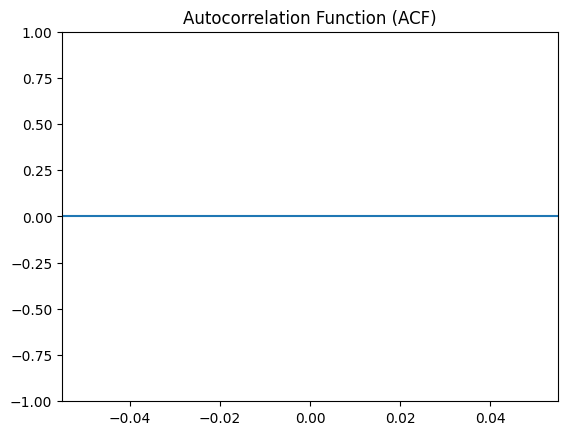

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


<Figure size 1200x600 with 0 Axes>

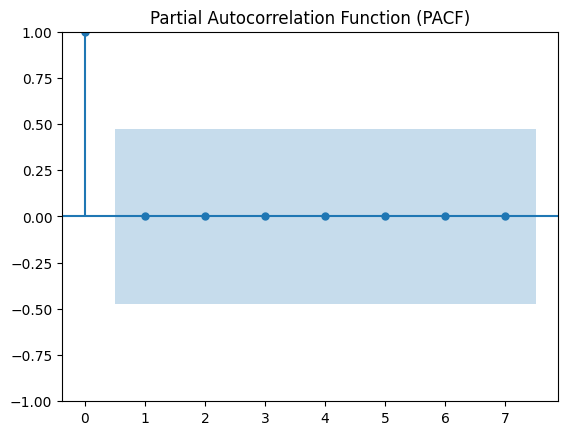

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   17
Model:                          ARIMA   Log Likelihood                -165.003
Date:                Sat, 05 Apr 2025   AIC                            334.005
Time:                        14:39:32   BIC                            335.672
Sample:                             0   HQIC                           334.171
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5129.2353    1.8e+04      0.284      0.776   -3.02e+04    4.05e+04
sigma2      1.574e+07   3.82e+0

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/commodities/commodities_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/commodities_saved_models"
filename = base_dir / "ml_models/commodities_saved_models/commodities_parameters.csv"
allYearsFilename = base_dir / "data/commodities/commodities_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("COMMODITIES_WEBPAGE_PATH"), 
                                             os.getenv("COMMODITIES_DATE_PATH"),
                                             os.getenv("COMMODITIES_SUBMIT_BUTTON_PATH"),
                                             os.getenv("COMMODITIES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
